# Dimensionality reduction

One of the first and most important steps of analyzing any dataset is visualizing it. However, many types of data that we regularly analyze have more than three dimensions (i.e., they have more than 3 variables; e.g., nucleotide sequence, chemical, nutritional, or sensory data, etc). The human brain is not very good at visualizing data in more than three dimensions. It is very difficult to understand any potential structure of the data because it is impossible to visualize a multi-dimensional hyperplane. However, this does not mean that there is no escape from the ["Curse of Dimensionality"](https://en.wikipedia.org/wiki/Curse_of_dimensionality), as this problem is referred to in the machine learning domain. To circumvent this issue, we can apply certain techniques which have the ability to transform a highly dimensional dataset with potentially thousands of features to a new one with 2, 3 or as many dimensions as are needed. The most fascinating part is that they can do  this by retaining the most important information that the highly-dimensional dataset conveys. Below we will explore some of the most used dimensionality reduction techniques in the [Wine Quality dataset taken from UC Irvine Machine Learning Repository](https://doi.org/10.24432/C56S3T).

## Environment setup

In [ ]:
# for Google Colab
import os
if 'COLAB_JUPYTER_IP' in os.environ:
    !git clone https://github.com/bokulich-lab/DataVisualizationBook.git book

    from book.utils import utils
    utils.ensure_packages('book/requirements.txt')

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP

# this is to silence pandas' warnings
import warnings
warnings.simplefilter(action='ignore')
%config InlineBackend.figure_format='svg'

# for Google Colab
if 'COLAB_JUPYTER_IP' in os.environ:
    data_dir = 'book/chapters/data'
else:
    data_dir = 'data'

# for plots' appearance
FONT_FAMILY = 'DejaVu Sans'
FONT_SCALE = 1.3

## Dataset pre-processing

The `red_wine` dataset contains 1599 records and 12 columns. The `white_whine` dataset on the other hand contains 4898 rows and 12 columns.

In [2]:
red_wine = pd.read_csv(f'{data_dir}/winequality-red.csv', sep=';')
white_wine = pd.read_csv(f'{data_dir}/winequality-white.csv', sep=';')

# add the label to distinguish those in the visualization phase
red_wine['label'] = 'red'
white_wine['label'] = 'white'

In [3]:
red_wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality label  
0      9.4        5   red  
1      9.8        5   red  
2      9.8        5   red  
3      9.8        6   red  
4      9.4        5   red

In [4]:
red_wine.shape

(1599, 13)

In [5]:
white_wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  label  
0      8.8        6  white  
1      9.5        6  white  
2     10.1        6  white  
3      9.9        6  white  
4      9.9        6  white

In [6]:
white_wine.shape

(4898, 13)

After loading, we will combine them in a single dataset.

In [7]:
wine_dataset = pd.concat([red_wine, white_wine], axis = 0)

In [8]:
wine_dataset.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality label  
0      9.4        5   red  
1      9.8        5   red  
2      9.8        5   red  
3      9.8        6   red  
4      9.4        5   red

In [9]:
wine_dataset.shape

(6497, 13)

As you can see, the resulting dataset contains 6497 rows and 13 columns, the total of white and red wine rows. Now we are ready to apply dimensionality reduction techniques to visualize these data. There are 13 features, which we will reduce to 2 (excluding the "label" column, which we will keep for visualization later on).

**NOTE:** As some of the methods rely on calculating distances between points in the dataset, we first scale all the attributes using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from scikit learn, so that all dimensions will have the same importance when calculating the low dimensional values.

````{margin}
```{note}
StandardScaler will remove the mean from each point and scale it to unit variance.
```
````

In [10]:
sc = StandardScaler()
wine_scaled = sc.fit_transform(wine_dataset.iloc[:, :-1])

# show the output of some columns after scaling
pd.DataFrame(wine_scaled, columns=wine_dataset.columns[:-1]).head().iloc[:, :4]

fixed acidity  volatile acidity  citric acid  residual sugar
0       0.142473          2.188833    -2.192833       -0.744778
1       0.451036          3.282235    -2.192833       -0.597640
2       0.451036          2.553300    -1.917553       -0.660699
3       3.073817         -0.362438     1.661085       -0.744778
4       0.142473          2.188833    -2.192833       -0.744778

```{warning}
We will not focus here on how any of the dimensionality reduction techniques actually achieve the reduction of dataset complexity. For more formal mathematical information and insights please refer to [this Wikipedia](https://en.wikipedia.org/wiki/Dimensionality_reduction) article about PCA, tSNE, UMAP and other dimensionality reduction techniques.
```

## Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a technique that allows projection of data from a highly dimensional space to a low dimensional one. PCA is very helpful for visualizations because it helps us reduce a dataset from many to 2 or 3 dimensions by retaining most of the information present and then visualize it. Usually, after applying PCA the most uncorrelated features are retained - the algorithm finds the features that give the most information about the data. Below we will see how we can apply PCA to our wine dataset.

````{margin}
```{note}
For more information please refer to: [PCA](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad).
```
````

As explained above, we input the scaled data to the PCA algorithm:

In [11]:
pca = PCA(n_components=2)
pca_components = pd.DataFrame(
    pca.fit_transform(wine_scaled), 
    columns=['dim_1', 'dim_2']
)

In [12]:
pca_components.head()

dim_1     dim_2
0 -3.348438  0.568926
1 -3.228595  1.197335
2 -3.237468  0.952580
3 -1.672561  1.600583
4 -3.348438  0.568926

In [13]:
labels = wine_dataset.iloc[:, -1].reset_index()
low_dimensional_data_pca = pd.concat([pca_components, labels], axis=1)

In [14]:
low_dimensional_data_pca.drop(columns=['index']).head()

dim_1     dim_2 label
0 -3.348438  0.568926   red
1 -3.228595  1.197335   red
2 -3.237468  0.952580   red
3 -1.672561  1.600583   red
4 -3.348438  0.568926   red

Now, we are ready to see how the dataset looks in 2 dimensions. As a reminder, we started with a dataset comprised of 12 features, excluding the labels. Using PCA we compressed the same dataset in 2 features (dimensions). Below, the dataset shows how the records mapped in the 2D coordinate system look like. The number of dimensions is a parameter that we can freely choose for the model - we picked 2 dimensions as it is easier for people to perceive things in 2 or 3 dimensions.

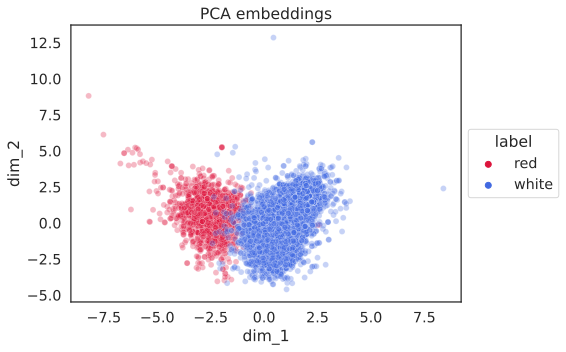

In [19]:
sns.set(
    rc={'figure.figsize':(7, 5), 
        'font.family': [FONT_FAMILY]}, 
    style='white'
)
with sns.plotting_context("notebook", font_scale=FONT_SCALE):
    ax = sns.scatterplot(
        data=low_dimensional_data_pca,
        x='dim_1', y='dim_2',
        alpha=0.3, hue='label',
        palette=['crimson', 'royalblue']
    )
    ax.set(title='PCA embeddings')
    sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))

As we can see from the plot, the two types of wine are clearly separated, with a little overlap.

## t-Distributed Stochastic Neighbor Embedding (tSNE)

t-SNE is another dimensionality reduction technique. However, while PCA tries to put differing points further apart, tSNE focuses on bringing similiar points closer to one another. In addition, tSNE does not preserve inter-cluster distances.

Now, let us apply t-SNE and see how it will represent the data in the low-dimensional space. Again, distances between points have to be calculated, so we input the scaled version of the dataset to the tSNE object. Next to the `n_components` hyperparameter, there is another parameter that can be tuned, the `perplexity`. It determines the number of neighbors that should be considered when calculating the distance for each point in the dataset (by default, `euclidian distance` is used). The more data points there are, the higher the perplexity should be. The default is 30.

````{margin}
```{note}
For more information please refer to: [tSNE](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1).
```
````

In [21]:
tsne = TSNE(n_components=2, perplexity=30)
tsne_components = pd.DataFrame(
    data=tsne.fit_transform(wine_scaled), 
    columns=['dim_1', 'dim_2']
)

After t-SNE calculates the components, we need to concatenate the returned DataFrame with the labels to be able to visualize it:

In [22]:
low_dimensional_data_tsne = pd.concat([tsne_components, labels], axis=1)
low_dimensional_data_tsne.head()

dim_1      dim_2  index label
0 -30.355177 -28.724136      0   red
1 -32.999695 -42.039455      1   red
2 -33.256638 -41.566692      2   red
3 -68.207123 -55.761543      3   red
4 -30.355394 -28.724407      4   red

Now, time to visualize the findings:

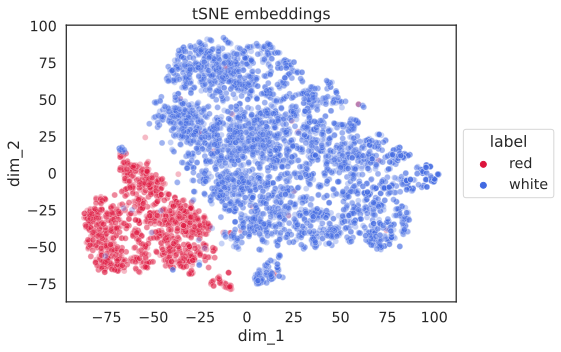

In [23]:
sns.set(
    rc={'figure.figsize':(7, 5), 
        'font.family': [FONT_FAMILY]}, 
    style='white'
)
with sns.plotting_context("notebook", font_scale=FONT_SCALE):
    ax = sns.scatterplot(
        data = low_dimensional_data_tsne,
        x='dim_1', y='dim_2', 
        alpha=0.3, hue='label',
        palette=['crimson', 'royalblue']
    )
    ax.set(title='tSNE embeddings')
    sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))

In this case, t-SNE has separated the two groups of wine although there are some points that are on the wrong side. In additiion, we see that the low dimensional data are more spread now.

## Uniform Approximation and Projection (UMAP)

UMAP is the third dimensionality reduction method that we are going to explore. Usually it performs better then t-SNE for large datasets and it is known for preserving the global structure of the clusters as well as the inter-cluster distances.

The hyperparameters that can be set by us here are `n_components`, `n_neighbors` and `min_dist` (although we do not tune this here). The `n_components`, as in PCA and t-SNE, determines the number of dimensions in the low dimensional space. The `n_neighbors` is the number of neighbors that should be considered when calculating the distances. In order to have deterministic results we pass the `random_state=0`. Since the algorithm deals with distances, again the data that we pass to it is scaled using a StandardScaler object.

````{margin}
```{note}
For more information please refer to: [UMAP](https://towardsdatascience.com/umap-dimensionality-reduction-an-incredibly-robust-machine-learning-algorithm-b5acb01de568).
```
````

In [24]:
umap = UMAP(n_components=2, n_neighbors=8, random_state=0)
umap_components = pd.DataFrame(
    data=umap.fit_transform(wine_scaled), 
    columns=['dim_1', 'dim_2']
)

Again, we concatenate the low dimensional data with the labels that we will need for the visualization.

In [25]:
low_dimensional_data_umap = pd.concat([umap_components, labels], axis=1)
low_dimensional_data_umap.head()

dim_1     dim_2  index label
0  2.205933 -2.834531      0   red
1  1.666038 -2.621844      1   red
2  1.807068 -2.548566      2   red
3 -0.831901 -0.173085      3   red
4  2.208013 -2.817780      4   red

Here you can see how the low dimensional embeddings with UMAP look like in a 2D plot.

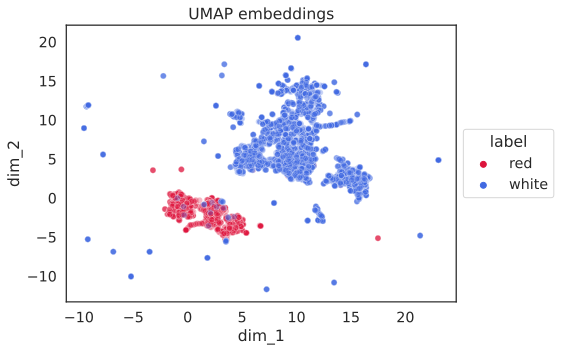

In [26]:
sns.set(
    rc={'figure.figsize':(7, 5), 
        'font.family': [FONT_FAMILY]}, 
    style='white'
)
with sns.plotting_context("notebook", font_scale=FONT_SCALE):
    ax = sns.scatterplot(
        data = low_dimensional_data_umap,
        x='dim_1', y='dim_2', 
        alpha=0.3, hue='label',
        palette=['crimson', 'royalblue']
    )
    ax.set(title='UMAP embeddings')
    sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))

This concludes our discussion about the ways to reduce the dimensionality of any dataset. Below you will find a short summary of the three methods presented in this chapter. Next, we will try to put together some of what we have been discussing so far and use it to look at a new dataset.

| Technique  | PCA                   | t-SNE               | UMAP                     |
|------------|-----------------------|---------------------|--------------------------|
| Method     | Linear                | Nonlinear           | Nonlinear                |
| Speed      | Fast                  | Relatively slow     | Fast                     |
| Global structure | Well preserved       | Poorly preserved  | Well preserved           |
| Local structure | Poorly preserved      | Well preserved    | Well preserved           |
| Deterministic | Yes                  | No (random seed)   | No |